
# Model Building Jupyter Notebook
This Jupyter Notebook serves as the main file for constructing machine learning models and building appropriate feature sets. The notebook is organized into four key sections:

### 1. Data Pre-Processing
In this section, we will ensure the data is adequately processed for model building. We will:

- Assess the current state of data processing.

- Identify any additional features that need to be added to improve model efficiency.
### 2. Model Building
- Here, we will develop the initial models that will be trained on the data processed in the previous section. This section focuses on:

- Constructing the models without fine-tuning or interpretation at this stage.
### 3. Model Training and Evaluation
In this section, we will:

- Train the models using the prepared data.

- Evaluate the performance of each model.

- Determine if the model outputs are reliable and worth further consideration.
### 4. Results
The final section will involve analyzing the decision-making process of the models. We will:

- Examine the results of linear regression models.

- For more advanced algorithms, delve into both local and global interpretations to understand the decision-making of these "black box" models.


#### Setting up Enviornment 

In [2]:
import pandas as pd # This is to read csv files
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc # Classification Evaluation
from sklearn.linear_model import LogisticRegression # Logit Regression
import statsmodels.api as sm # For proper results interpretation of models
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler # Different type of scaling

# For LSTM Development 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import matplotlib.pyplot as plt # General Plotting
import os 
import sys
import importlib
path = ('P:/6. DSMA/99. Thesis/Github/thesis')
os.chdir(path)

# Import the module
sys.path.append('P:/6. DSMA/99. Thesis/Github/thesis/scripts')
import pipeline_crypto_prices
from pipeline_crypto_prices import get_prices
import camel
import sentiment_analyzer
importlib.reload(pipeline_crypto_prices)
importlib.reload(camel)
importlib.reload(sentiment_analyzer)

<module 'sentiment_analyzer' from 'P:\\6. DSMA/99. Thesis/Github/thesis/scripts\\sentiment_analyzer.py'>

In [98]:
btc = pd.read_csv('data/processed/camel_v3_btc.csv').drop('Unnamed: 0', axis=1)
eth = pd.read_csv('data/processed/camel_v3_eth.csv').drop('Unnamed: 0', axis=1)
sol = pd.read_csv('data/processed/camel_v3_sol.csv').drop('Unnamed: 0', axis=1)

btc.index = pd.to_datetime(btc.Date)
eth.index = pd.to_datetime(eth.Date)
sol.index = pd.to_datetime(sol.Date)

btc = btc.drop(['Date', 'Close','ups','date','ATR_td', 'Dow_Returns', 'Dow_Volume', 'Oil_Returns', 'Oil_Volume','High','Low','unweighted_mean_sentiment'], axis=1)
eth = eth.drop(['Date', 'Close','ups','date','ATR_td', 'Dow_Returns', 'Dow_Volume', 'Oil_Returns', 'Oil_Volume','High','Low','unweighted_mean_sentiment'], axis=1)
sol = sol.drop(['Date', 'Close','ups','date','ATR_td', 'Dow_Returns', 'Dow_Volume', 'Oil_Returns', 'Oil_Volume','High', 'Low','unweighted_mean_sentiment'], axis=1)

btc.Indicator = np.where(btc.Indicator == 'Buy', 1, 0)
eth.Indicator = np.where(eth.Indicator == 'Buy', 1, 0)
sol.Indicator = np.where(sol.Indicator == 'Buy', 1, 0)

#### Preparing the model dataset

##### Making lagged variables for non time series models 

In [99]:
btc_m, eth_m, sol_m = camel.thesis_lag(btc, num_lags = 3, target_column = 'Indicator'), camel.thesis_lag(eth, num_lags = 3, target_column = 'Indicator'), camel.thesis_lag(sol, num_lags = 3, target_column = 'Indicator')

##### Initializing Training and Test Datasets

In [100]:
btc_1, eth_1, sol_1 = btc_m, eth_m, sol_m


def prepare_data_and_calculate_vif(df, target_column='Indicator', split_ratio=0.8):
    # Get all column names except the target column
    columns = df.drop(columns=target_column).columns.tolist()

    # Select the columns for X and y
    X = df[columns]
    y = df[target_column]

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Convert scaled features back to DataFrame to retain column names
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    # Split data into training and test sets while respecting the temporal order
    split_index = int(len(df) * split_ratio)
    X_train, X_test = X_scaled_df[:split_index], X_scaled_df[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Calculate VIF for each feature
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])]
    vif["features"] = X_scaled_df.columns

    return X_train, X_test, y_train, y_test, vif

btc_x_train, btc_x_test, btc_y_train, btc_y_test, btc_vif = prepare_data_and_calculate_vif(btc_1)
eth_x_train, eth_x_test, eth_y_train, eth_y_test, eth_vif = prepare_data_and_calculate_vif(eth_1)
sol_x_train, sol_x_test, sol_y_train, sol_y_test, sol_vif = prepare_data_and_calculate_vif(sol_1)

In [39]:
# Check for inf values
if np.isinf(X).values.any():
    print("There are inf values in the dataset.")

# Check for NaN values
if np.isnan(X).values.any():
    print("There are NaN values in the dataset.")

#### Model 1: RandomForest Regression

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def train_evaluate_random_forest(X_train, X_test, y_train, y_test, n_estimators=15, max_depth=30, min_samples_split=5):
    # Initialize and train the Random Forest model
    rfm = RandomForestClassifier(n_estimators=n_estimators, bootstrap=True, 
                                 max_depth=max_depth, min_samples_split=min_samples_split)
    rfm.fit(X_train, y_train)
    
    # Make predictions
    rf_pred = rfm.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, rf_pred)
    conf_matrix = confusion_matrix(y_test, rf_pred)
    class_report = classification_report(y_test, rf_pred)
    
    # Print results
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    #print("Classification Report:")
    #print(class_report)
    
    # Return the model and predictions for further use if needed
    return rfm, rf_pred

btc_rfm, btc_rf_pred = train_evaluate_random_forest(btc_x_train, btc_x_test, btc_y_train, btc_y_test)
eth_rfm, eth_rf_pred = train_evaluate_random_forest(eth_x_train, eth_x_test, eth_y_train, eth_y_test)
sol_rfm, sol_rf_pred = train_evaluate_random_forest(sol_x_train, sol_x_test, sol_y_train, sol_y_test)

Accuracy: 0.5625
Confusion Matrix:
[[ 9 11]
 [ 3  9]]
Accuracy: 0.5625
Confusion Matrix:
[[11  7]
 [ 7  7]]
Accuracy: 0.53125
Confusion Matrix:
[[8 7]
 [8 9]]


ROC Curve to test model evaluation

###### The ROC (Receiver Operating Characteristic) curve is a graphical representation used to evaluate the performance of a classification model. It plots the true positive rate (sensitivity) against the false positive rate (1-specificity) across various threshold settings. The curve illustrates the trade-off between sensitivity and specificity: as one increases, the other may decrease. The area under the curve (AUC) provides a single scalar value to summarize the model's ability to distinguish between the positive and negative classes, with an AUC of 1 indicating perfect classification and an AUC of 0.5 suggesting no better than random chance. Thus, the ROC curve and AUC are valuable tools for assessing and comparing the discriminatory power of different classifiers.

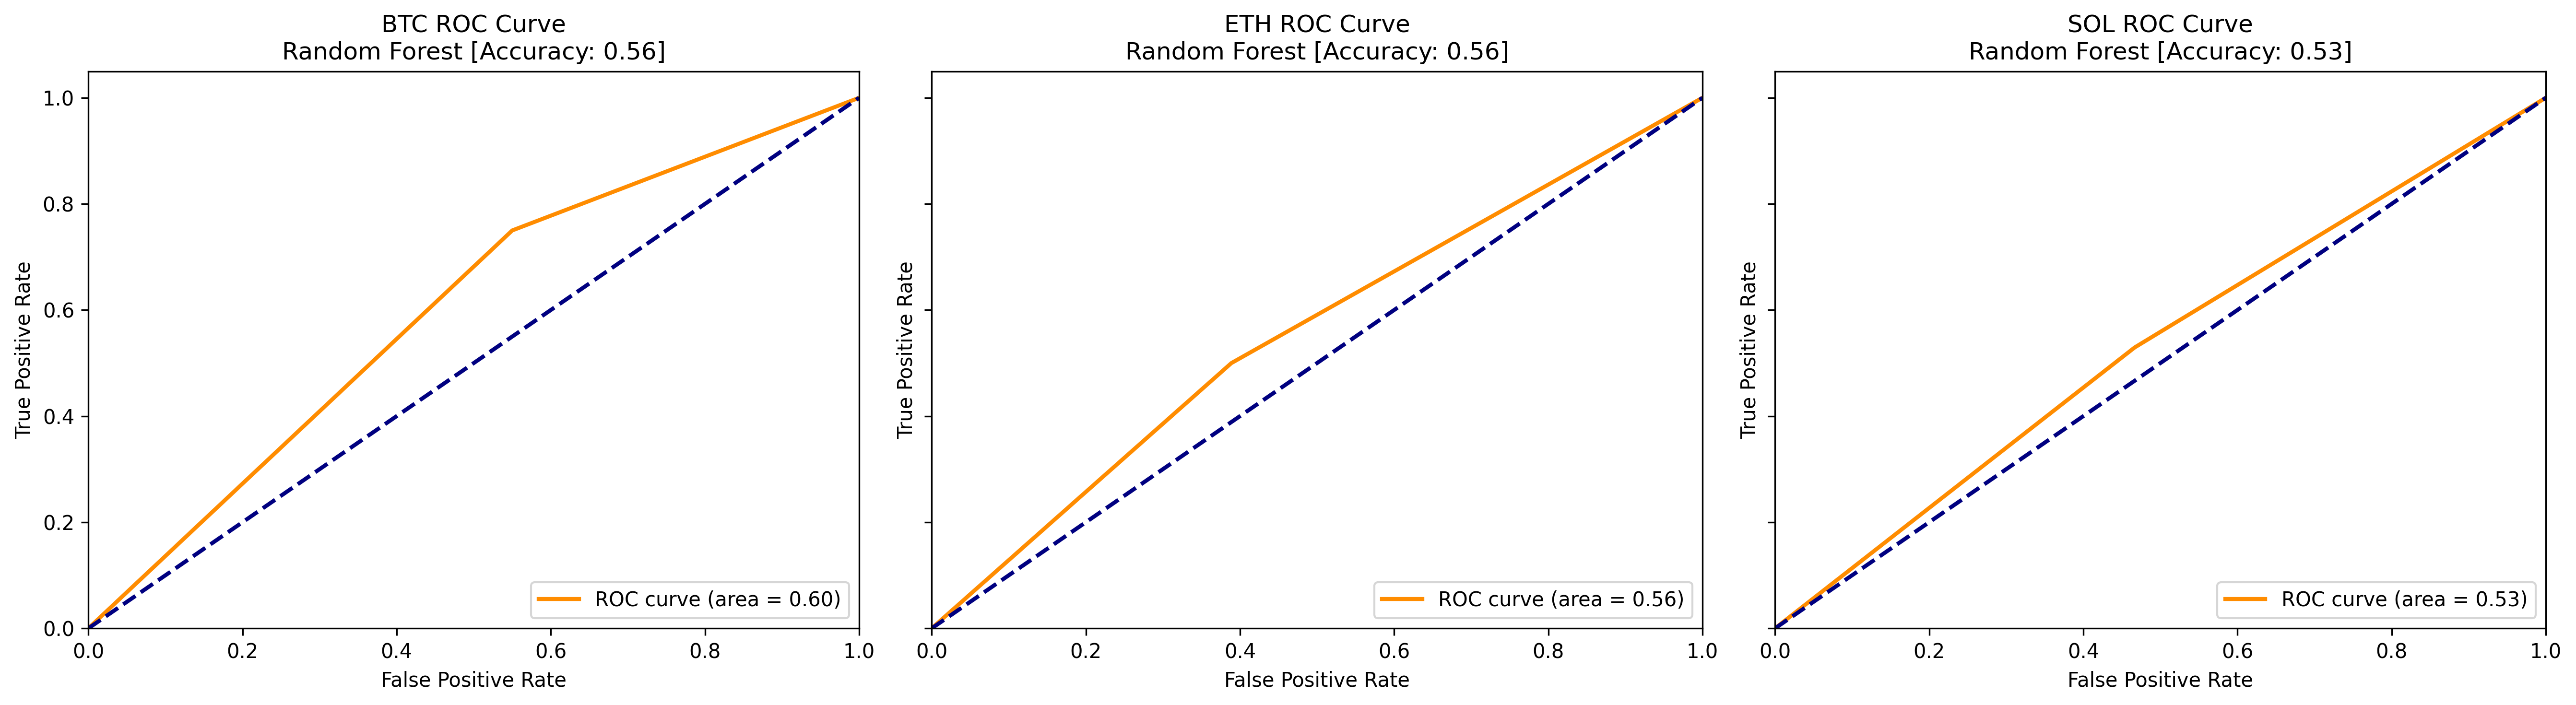

In [111]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, y_pred, crypto_name, ax):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    accuracy = (y_test == y_pred).mean()

    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{crypto_name} ROC Curve\nRandom Forest [Accuracy: {accuracy:.2f}]')
    ax.legend(loc="lower right")

# List of cryptocurrencies and their corresponding data
cryptos = [
    ('BTC', btc_y_test, btc_rf_pred),
    ('ETH', eth_y_test, eth_rf_pred),
    ('SOL', sol_y_test, sol_rf_pred)
]

# Create a figure with subplots for each cryptocurrency
n_cryptos = len(cryptos)
fig, axes = plt.subplots(1, n_cryptos, figsize=(6*n_cryptos, 5), dpi=300, sharey=True)

# Loop through the cryptocurrencies and plot their ROC curves
for (crypto_name, y_test, rf_pred), ax in zip(cryptos, axes):
    plot_roc_curve(y_test, rf_pred, crypto_name, ax)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()



#### Model 2: Support Vector Machine (SVM)

In [172]:
from sklearn.svm import SVC

model = SVC(C = 7, probability=True, gamma='auto', kernel='sigmoid')
model.fit(X_train, y_train)

svm_pred = model.predict(X_test)

In [173]:
# Evaluate the model
accuracy = accuracy_score(y_test, svm_pred)
conf_matrix = confusion_matrix(y_test, svm_pred)
class_report = classification_report(y_test, svm_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.5454545454545454
Confusion Matrix:
[[ 8 13]
 [ 2 10]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.38      0.52        21
           1       0.43      0.83      0.57        12

    accuracy                           0.55        33
   macro avg       0.62      0.61      0.54        33
weighted avg       0.67      0.55      0.54        33



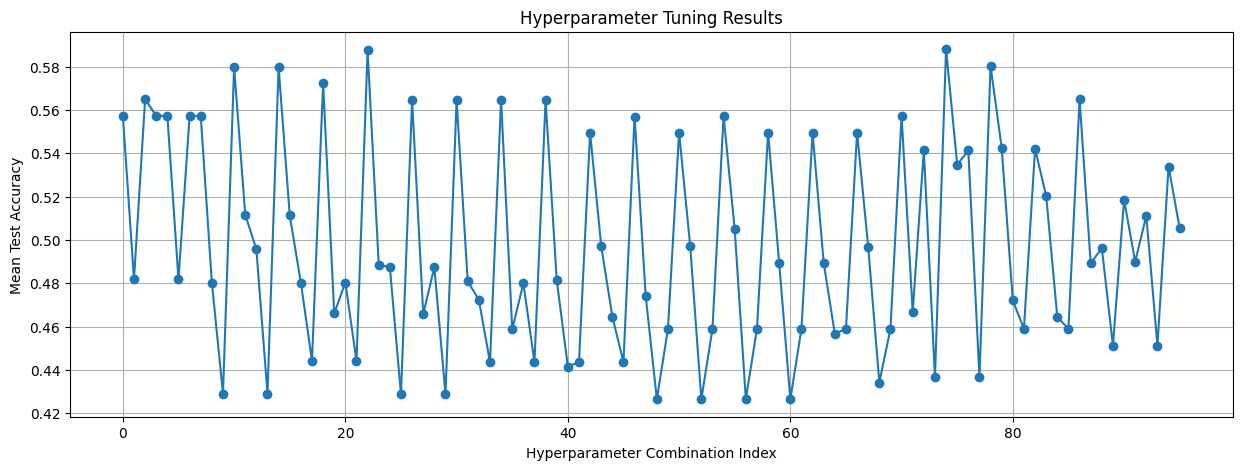

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Best Accuracy: 0.5880
Test Accuracy: 0.3333


In [153]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {
    'C': [0.1, 2,3,4,5,6,7,8,9, 1, 10, 100],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Initialize the SVC model
svc = SVC(probability=True)

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model with training data
grid_search.fit(X_train, y_train)

# Get the results of the grid search
results = grid_search.cv_results_

# Extract relevant information
mean_test_scores = results['mean_test_score']
params = results['params']

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(range(len(mean_test_scores)), mean_test_scores, marker='o')
plt.title('Hyperparameter Tuning Results')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Mean Test Accuracy')
plt.grid(True)
plt.show()

# Print the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.4f}")

# Use the best model to make predictions
best_model = grid_search.best_estimator_
svm_pred = best_model.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, svm_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


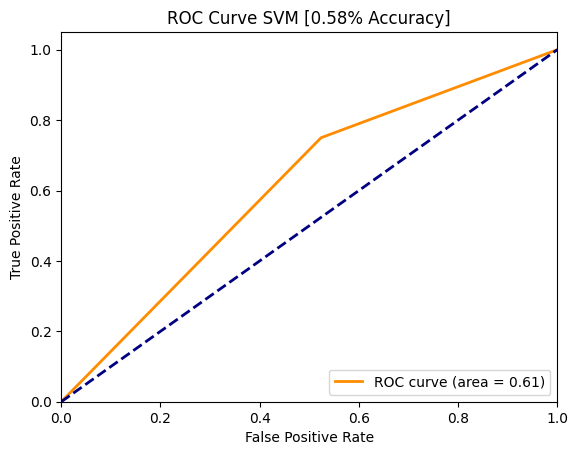

In [120]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, svm_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve SVM [{accuracy:.2f}% Accuracy]')
plt.legend(loc="lower right")
plt.show()

In [174]:
import shap 

# Create and fit the explainer
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)

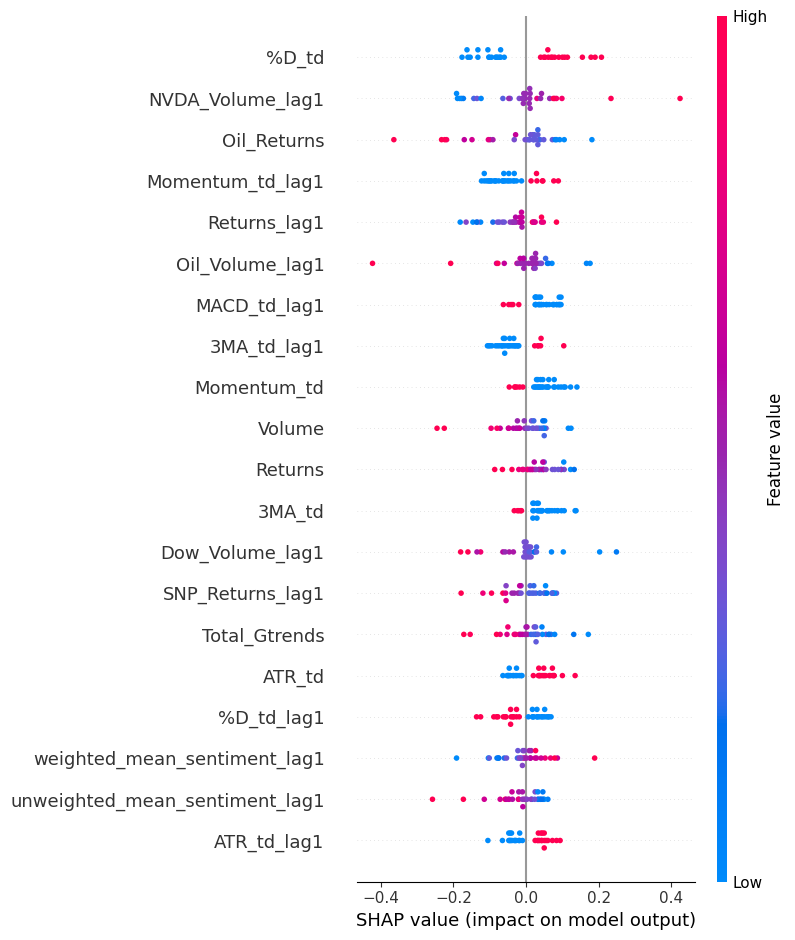

In [175]:
 shap.summary_plot(shap_values, X_test, feature_names=X_test.columns.tolist())

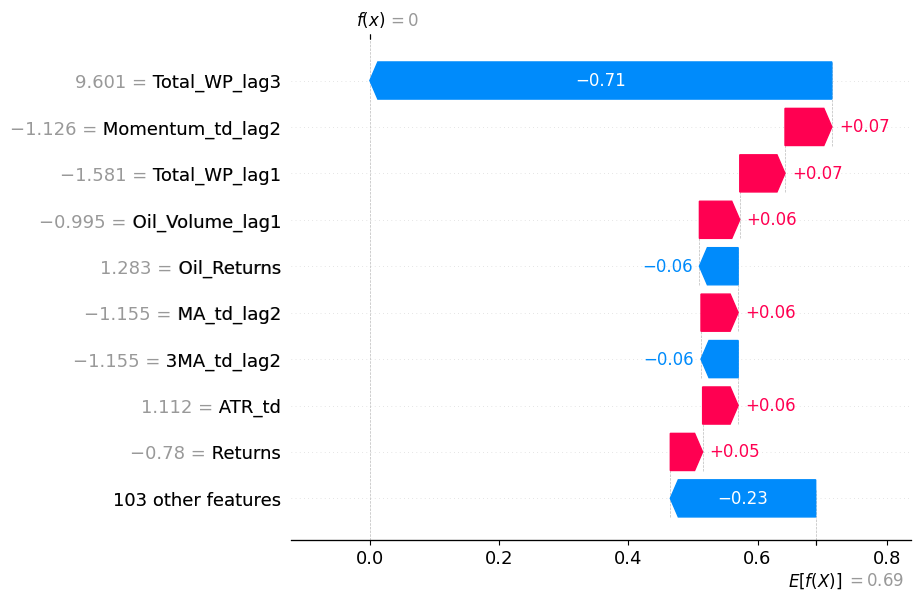

The actual value for the 12th instance is: 0


In [123]:
shap.waterfall_plot(shap_values[12])

# Show the plot
plt.show()

# Fetch the actual value for the 12th instance from y_test
actual_value = y_test.iloc[12]  # Assuming y_test is a DataFrame or Series

print(f"The actual value for the 12th instance is: {actual_value}")

#### Model 3: GradientBoosting

In [104]:
y_encoded_train

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1])

In [181]:
import xgboost as xgb

# Create the DMatrix data format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the parameters for the XGBoost model
params = {
    'objective': 'binary:logistic',  # Binary classification
    'max_depth': 100,                  # Maximum depth of a tree
    'eta': 0.01,                      # Learning rate
    'eval_metric': 'logloss'         # Evaluation metric
}

# Train the model
num_rounds = 2
bst = xgb.train(params, dtrain, num_rounds)

# Predict the labels of the test set
y_pred_prob = bst.predict(dtest)
xg_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, xg_pred)
conf_matrix = confusion_matrix(y_test, xg_pred)
class_report = classification_report(y_test, xg_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.5152
Confusion Matrix:
[[10 11]
 [ 5  7]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.48      0.56        21
           1       0.39      0.58      0.47        12

    accuracy                           0.52        33
   macro avg       0.53      0.53      0.51        33
weighted avg       0.57      0.52      0.52        33



In [179]:
y_train

Date
2024-01-28    1
2024-01-29    0
2024-01-30    0
2024-01-31    1
2024-02-01    1
             ..
2024-06-01    1
2024-06-02    1
2024-06-03    1
2024-06-04    1
2024-06-05    0
Name: Indicator, Length: 130, dtype: int32

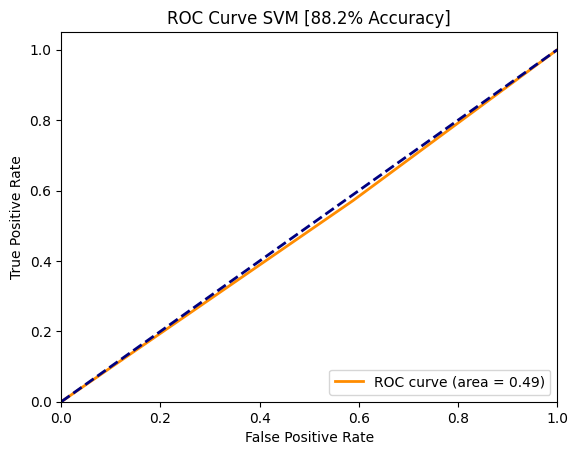

In [26]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, xg_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVM [88.2% Accuracy]')
plt.legend(loc="lower right")
plt.show()

#### Model 4: Long Short Term Memory (LSTM)

In [216]:
btc.index = pd.to_datetime(btc.index)
btc_lstm = btc.sort_index()
btc_lstm['Indicator'] = np.where(btc_lstm['Indicator'] == 'Buy', 1, 0)

btc_lstm.replace([np.inf, -np.inf], np.nan, inplace=True)
btc_lstm.dropna(inplace=True)


# Get all column names except 'Tomorrow'
columns = btc_lstm.drop(columns='Indicator').columns.tolist()

# Normalize the feature columns
feature_scaler = MinMaxScaler()
btc_lstm[columns] = feature_scaler.fit_transform(btc_lstm[columns])

# Normalize the target column separately
target_scaler = MinMaxScaler()
btc_lstm['Indicator'] = target_scaler.fit_transform(btc_lstm['Indicator'].values.reshape(-1, 1))
# Function to create sequences
def create_sequences(data, target, past_days):
    sequences = []
    labels = []
    for i in range(past_days, len(data)):
        sequences.append(data[i-past_days:i])
        labels.append(target[i])
    return np.array(sequences), np.array(labels)

# Extract the feature columns and the target column
feature_data = btc_lstm[columns].values
target_data = btc_lstm['Indicator'].values

# Create sequences with 3 past days
past_days = 5
X, y = create_sequences(feature_data, target_data, past_days)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape X for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(columns)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(columns)))

In [224]:
from keras.metrics import Recall


# Build the LSTM model
model = Sequential()
model.add(LSTM(80, return_sequences=True, input_shape=(past_days, len(columns))))

model.add(Dropout(0.2)) 
model.add(LSTM(120, return_sequences=True))

model.add(Dropout(0.2)) 
model.add(LSTM(120, return_sequences=True))

model.add(Dropout(0.2))  
model.add(LSTM(20))

model.add(Dropout(0.2)) 
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[camel.f1_score])  # Use binary_crossentropy for binary classification

In [225]:
# Fit the model
model.fit(X_train, y_train, epochs=30, batch_size=12, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions_lstm = model.predict(X_test)
predictions_lstm = target_scaler.inverse_transform(predictions_lstm)
y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))

print('Predicted vs Actual form the model')
print('')
# Display the first 10 predictions and actual values
for i in range(10):
    print(f'Predicted: {predictions_lstm[i][0]}, Actual: {y_test[i][0]}')

# Evaluate the model

binary_predictions = (predictions_lstm > 0.5).astype(int)
accuracy = accuracy_score(y_test, binary_predictions)
conf_matrix = confusion_matrix(y_test, binary_predictions)
class_report = classification_report(y_test, binary_predictions)
print('')
print('')
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Epoch 1/30
11/11 [==============================] - 6s 121ms/step - loss: 0.6941 - f1_score: 0.5795 - val_loss: 0.6882 - val_f1_score: 0.6707
Epoch 2/30
11/11 [==============================] - 0s 11ms/step - loss: 0.6947 - f1_score: 0.6757 - val_loss: 0.6883 - val_f1_score: 0.6707
Epoch 3/30
11/11 [==============================] - 0s 11ms/step - loss: 0.6926 - f1_score: 0.6798 - val_loss: 0.6864 - val_f1_score: 0.6707
Epoch 4/30
11/11 [==============================] - 0s 11ms/step - loss: 0.6916 - f1_score: 0.6762 - val_loss: 0.6825 - val_f1_score: 0.6707
Epoch 5/30
11/11 [==============================] - 0s 11ms/step - loss: 0.6887 - f1_score: 0.6944 - val_loss: 0.6793 - val_f1_score: 0.7026
Epoch 6/30
11/11 [==============================] - 0s 11ms/step - loss: 0.6841 - f1_score: 0.6654 - val_loss: 0.6616 - val_f1_score: 0.7026
Epoch 7/30
11/11 [==============================] - 0s 11ms/step - loss: 0.6742 - f1_score: 0.6280 - val_loss: 0.6462 - val_f1_score: 0.7304
Epoch 8/30
1

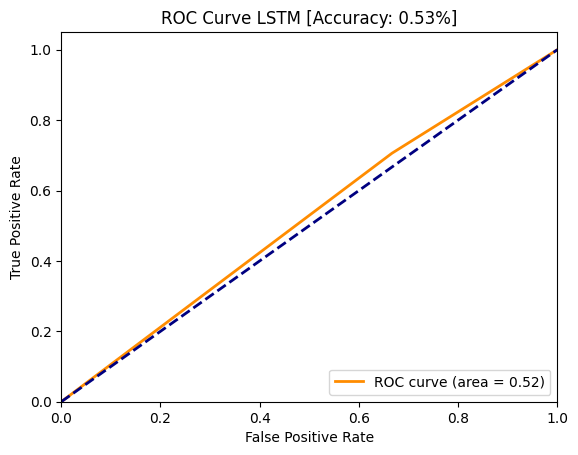

In [227]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, binary_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve LSTM [Accuracy: {accuracy:.2f}%]')
plt.legend(loc="lower right")
plt.show()

In [228]:
import tensorflow as tf
import matplotlib.pyplot as plt
import shap
import numpy as np

# Function to get the gradients of the model's output with respect to the input
def get_saliency_map(model, input_data, target_index):
    input_data = tf.convert_to_tensor(input_data)
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        prediction = model(input_data)
        loss = prediction[:, target_index]
    gradient = tape.gradient(loss, input_data)
    return gradient

# Get a single input sample to compute the saliency map
input_sample = X_test[7:8]

# Compute the saliency map for the sample
saliency_map = get_saliency_map(model, input_sample, 0).numpy().squeeze()


In [229]:
saliency = pd.DataFrame(saliency_map, columns=columns)
saliency = saliency.transpose()
saliency = saliency.sort_values(by=0, ascending=False)
saliency = saliency[:5]
saliency

,0,1,2,3,4
RSI_td,0.104099,0.057220,0.028502,0.010478,0.002489
Oil_Volume,0.096293,0.054619,0.029254,0.010547,0.002512
3MA_td,0.081180,0.045811,0.025831,0.009606,0.002387
MACD_td,0.070218,0.040360,0.019133,0.006005,0.001214
Total_Gtrends,0.062978,0.033709,0.016309,0.005976,0.001398


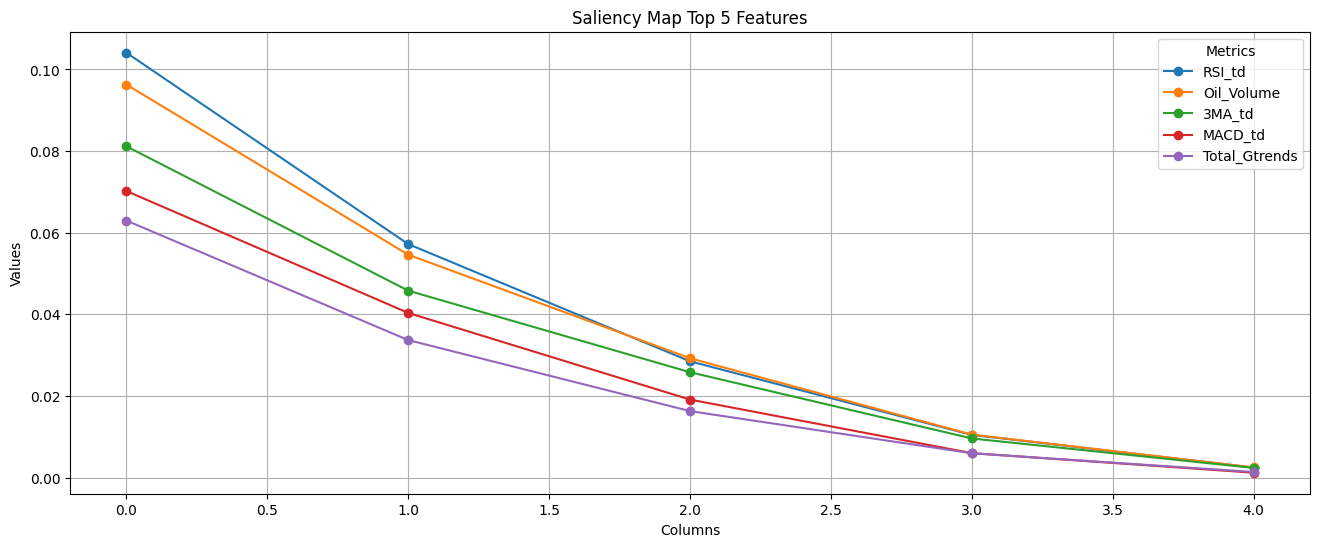

In [230]:
# Plot each row as a separate line chart
plt.figure(figsize=(16, 6))
for row in saliency.index:
    plt.plot(saliency.columns, saliency.loc[row], marker='o', label=row)
plt.title('Saliency Map Top 5 Features')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.legend(title='Metrics')
plt.grid(True)
plt.show()

#### Model 5: Hidden Markov Model

In [326]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode the 'Indicator' column
label_encoder = LabelEncoder()
btc['Indicator'] = label_encoder.fit_transform(btc['Indicator'])

# Separate features and target variable
X = btc.drop(columns=['Indicator'])
y = btc['Indicator']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Combine features and target for HMM training
train_data = pd.DataFrame(X_train)
train_data['Indicator'] = y_train.values

test_data = pd.DataFrame(X_test)
test_data['Indicator'] = y_test.values

# Display the processed training data
train_data.head()

from hmmlearn import hmm
import numpy as np

# Prepare the data for HMM: X as sequences of observations, y as states
# We need to reshape the data as a sequence of sequences for HMM

# Define number of states and components
n_states = 2  # We have 'Buy' and 'Sell'
n_components = X_train.shape[1]  # Number of features

# Initialize the HMM
model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=3)

# Fit the model
model.fit(X_train)

# Predict the hidden states of the training data
hidden_states = model.predict(X_train)

# Predict the hidden states of the test data
hidden_states_test = model.predict(X_test)

accuracy = accuracy_score(y_test, hidden_states_test)
conf_matrix = confusion_matrix(y_test, hidden_states_test)
class_report = classification_report(y_test, hidden_states_test)
print('')
print('')
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)




Accuracy: 0.58
Confusion Matrix:
[[24  5]
 [16  5]]
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.83      0.70        29
           1       0.50      0.24      0.32        21

    accuracy                           0.58        50
   macro avg       0.55      0.53      0.51        50
weighted avg       0.56      0.58      0.54        50



### Aggregations

In [61]:
rf_pred
svm_pred
xg_pred


stacked_predictions = np.vstack([rf_pred, svm_pred, xg_pred])
average_predictions = np.mean(stacked_predictions, axis=0)

# Convert average predictions to binary (0 or 1)
ensemble_predictions = (average_predictions > 0.5).astype(int)

ensemble_predictions.tolist()

ensemble_predictions

# Evaluate the model
accuracy = accuracy_score(y_test, ensemble_predictions)
conf_matrix = confusion_matrix(y_test, ensemble_predictions)
class_report = classification_report(y_test, ensemble_predictions)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.46153846153846156
Confusion Matrix:
[[8 8]
 [6 4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.50      0.53        16
           1       0.33      0.40      0.36        10

    accuracy                           0.46        26
   macro avg       0.45      0.45      0.45        26
weighted avg       0.48      0.46      0.47        26

